# Boat trip Data analysis

First we fetch the data from github.
By running the following command the data will be coppied in the cloud server where you are running this notebook, so you could access it :)

 You can also access the data in [here](https://github.com/franamor98/MIR_BOAT_DAY1_DATA.git)

In [1]:
!git clone https://github.com/franamor98/MIR_BOAT_DAY1_DATA.git

Cloning into 'MIR_BOAT_DAY1_DATA'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.


Now we are going to install some packages and import the modules used!

In [2]:
!pip install folium
!pip install geopy
!pip install ctd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import os 
from datetime import datetime as dt
from datetime import timedelta
from geopy.distance import geodesic
import folium
from folium import plugins
from sklearn.preprocessing import MinMaxScaler

#for CTD
import ctd
import matplotlib.pyplot as plt


## Drifters Analysis

### We are are ready to load our trip data from the log sheet

In [4]:
#Since its in csv format we can read it using the pandas module!
logSheet = pd.read_csv(f'./MIR_BOAT_DAY1_DATA/MIR_DAY1/logSheet.csv',encoding='utf8') 

#Next we apply to transformation to the data:

#Remove the id number extra digits, to get only the last 3 digits od the id, it is what we are using
logSheet['Id'] = logSheet['Id'].apply(lambda x: x[-3:])
#We want to convert the time as string to a datetime timestamp for both recover and deploy
logSheet['Deplyoment'] = [
    dt.strptime(f'{logSheet.iloc[i]["Deplyoment"]}:00', '%H:%M:%S') - timedelta(hours=2, minutes=0)
    for i in range(len(logSheet))
]

logSheet['Recovery'] = [
    dt.strptime(f'{logSheet.iloc[i]["Recovery"]}:00', '%H:%M:%S') - timedelta(hours=2, minutes=0)
    for i in range(len(logSheet))
]
#Now we can take a look at it
logSheet

,Station,Id,Type,Deplyoment,Lon,Lat,Recovery,Lon.1,Lat.1
0,1,273,Yellow 1m,1900-01-01 08:28:00,5º 59.928',43º 4.8',1900-01-01 12:05:00,5º 59.994,43º 5.342'
1,1,666,White surface,1900-01-01 08:28:00,5º 59.928',43º 4.8',1900-01-01 12:13:00,6º 0.194',43º 5.617'
2,1,439,White 60cm,1900-01-01 08:28:00,5º 59.928',43º 4.8',1900-01-01 12:10:00,5º 59.399',43º 5.403'
3,2,274,Yellow 1m,1900-01-01 08:42:00,5º 59.072',43º 4.695',1900-01-01 11:39:00,5º 59.423',43º 4.929'
4,2,436,White surface,1900-01-01 08:42:00,5º 59.072',43º 4.695',1900-01-01 11:38:00,5º 59.282',43º 4.958
5,2,368,White 60cm,1900-01-01 08:42:00,5º 59.072',43º 4.695',1900-01-01 11:35:00,5º 59.115',43º 4.993
6,3,230,White 60cm,1900-01-01 09:06:00,5º 58.405',43º 4.644',1900-01-01 11:56:00,5º 59.158',43º 4.44'
7,3,119,White surface,1900-01-01 09:06:00,5º 58.405',43º 4.644',1900-01-01 11:57:00,5º 59.192',43º 4.552'
8,3,277,Yellow 1m,1900-01-01 09:06:00,5º 58.405',43º 4.644',1900-01-01 11:56:00,5º 59.158',43º 4.44'
9,4,052,White 60cm,1900-01-01 09:43:00,6º 0.605',42º 59.533',1900-01-01 10:14:00,-,-


## Merge all drifters in a single DataFrame

In [5]:
drifter_folder = "./MIR_BOAT_DAY1_DATA/MIR_DAY1/MIR_DAY1_DRIFTERS/"
#First we read the white drifter data from the single csv containing all of them
df_all = pd.read_csv(f'{drifter_folder}drifter-10_11_22-05_49.csv',encoding='utf8')
#We remove the data we are not goin to use
df_all = df_all.drop(['BatteryStatus','CommId'], axis=1)
#We remove erroneous data
df_all = df_all.dropna()

#We iterate over the data folder and we only get the yellow drifters files (txt files)
for file in [i for i in os.listdir(drifter_folder) if i[-3:]=='txt']:
    #We get the id
    drifter_id = f'{file.split(".")[-2][-3:]}'#split filename by ".", get the second last, and get 3 last characters
    print(file)
    #read the csv, yes its a csv even if its termination its txt
    df = pd.read_csv(f'{drifter_folder}{file}',encoding='utf8')
    #We rename the time column like the white data is
    df = df.rename(columns={"Reception time (UTC)": "DeviceDateTime"})
    #create a new colunm with the id
    df['DeviceName'] = drifter_id
    #We remove the data we are not goin to use
    df = df.drop(['Position time (UTC)', 'Course (°)','Speed (m/s)','Status','Battery (V)','Temperature (°C)'], axis=1)
    #order the columns like the white ones
    df = df.loc[:, ["DeviceName","DeviceDateTime","Latitude","Longitude"]]
    #Append what we have to the big dataframe
    df_all = df_all.append(df)
    

LCI00277.txt
LCI00274.txt
LCI00273.txt


## Now we can apply the same processing for all of them
Please always execute the cell above before this step

In [6]:
pd.options.mode.chained_assignment = None  
#we create some dicts to store the clean data sorted by its type
yellow_drifters_df = {}
white_drifters_surface_df = {}
white_drifters_60_df = {}


#Cast date string to python datetime only 'caring' about the hours
df_all['DeviceDateTime'] = df_all['DeviceDateTime'].apply(lambda x: dt.strptime(x.split()[-1], '%H:%M:%S')) 
#Remove the id number extra digits, to get only the last 3 digits od the id, it is what we are using
df_all['DeviceName'] = df_all['DeviceName'].apply(lambda x: x[-3:])

#Sort the DataFrame by the time and reset the index
df_all=df_all.sort_values(by='DeviceDateTime').reset_index()


#We iterate over the logSheet entries
for index, row in logSheet.iterrows():
    
    #Filter the df to get only the signal after deployment and before recover
    df = df_all.loc[
        (df_all['DeviceName'] ==  row['Id']) # Id that we want
        & #and
        (df_all['DeviceDateTime'] > row['Deplyoment']) # DeviceDateTime is greater than deploy
        & #and
        (df_all['DeviceDateTime'] < row['Recovery']) # DeviceDateTime is smaller than recover
    ]
    
    #We make sure that there is some data
    if len(df)>0:
        
        #We compute the geodesic distance using geopy function, for all the values of this drifter
        #The new column we are creating its going to be filled with the array defined in the for loop
        df['distance'] = [ 
            #compute the distance
            geodesic(
                [df.iloc[i-1]['Latitude'],df.iloc[i-1]['Longitude']], #pos i-1
                [df.iloc[i]['Latitude'],df.iloc[i]['Longitude']] #pos i
            ).m
            if i>0 #not for the first element to avoid erros
            else np.finfo(float).eps #instead we fill it with an infinitesimal value to avoid dividing by 0
            for i in range(len(df)) #for i position such as i is the number of elements
        ]
        #compute the time delta
        df['time_delta'] = [ 
            #by resting time(i-1) and time(i) and gettings the seconds of it
            np.abs((df.iloc[i-1]['DeviceDateTime']-df.iloc[i]['DeviceDateTime']).total_seconds())
            if i>0
            else 1
            for i in range(len(df))
        ]
        #The velocity will be de  division of this values
        df['velocity'] = df['distance']/df['time_delta']
        
        # apply normalization techniques for velocity visualization
        df['vel_normalized'] = MinMaxScaler().fit_transform(np.array(df['velocity']).reshape(-1,1))
        
        #Depending of its type we put it in a place or another
        if '60' in row['Type']:
            white_drifters_60_df[row['Id']]=df
        elif 'surface' in row['Type']:
            white_drifters_surface_df[row['Id']]=df
        elif '1m' in row['Type']:
            yellow_drifters_df[row['Id']]=df

In [7]:
#We create a map object using folium
m = folium.Map(location=[43.05228, 5.94], zoom_start=12, tiles="Stamen Terrain")
#We add a raster layer using a wms service from emodnet thats provide bathymetry maps
folium.raster_layers.WmsTileLayer(url= 'https://ows.emodnet-bathymetry.eu/wms',
                                  layers = 'mean_rainbowcolour',
                                  opacity = 0.3,
                                  transparent = True, 
                                  control = True,
                                  fmt="image/png",
                                  name = 'bathymetry',
                                  overlay = True,
                                  show = True,
                                  ).add_to(m)
#add this last layer to the control
folium.LayerControl().add_to(m)

#for every tyoe of drifter we plot the trayectories
for key,item in white_drifters_60_df.items():
    
    #get some variables
    lats = item['Latitude'].tolist()
    lons = item['Longitude'].tolist()
    vels = item['velocity'].tolist()
    vels_normalized = item['vel_normalized'].tolist()

    #this next lines are to make the path animated, I think its a bit ugly
    #latslons = zip(lats,lons)
    #plugins.AntPath(latslons,color='white').add_to(m)
    
    #for every point
    for i in range(len(item['Latitude'].tolist())):
        
        #plot a marker whit a poppup and its intensity proportional to its velocity
        folium.CircleMarker(
            [lats[i],lons[i] ],
            opacity = 2*vels_normalized[i],
            radius=2,color='white',
            fill_color='black',
            popup=folium.Popup(f"z=0.6m: {round(vels[i],3)}m/s")
        ).add_to(m)


for key,item in white_drifters_surface_df.items():
    
    
    lats = item['Latitude'].tolist()
    lons = item['Longitude'].tolist()
    vels = item['velocity'].tolist()
    vels_normalized = item['vel_normalized'].tolist()

    
    #latslons = zip(lats,lons)
    #plugins.AntPath(latslons,color='#8da6c2').add_to(m)
    
    for i in range(len(item['Latitude'].tolist())):

        folium.CircleMarker(
            [lats[i],lons[i] ],
            opacity = 2*vels_normalized[i],
            radius=2,
            color='#785ebf',
            fill_color='white',
            popup=folium.Popup(f"z=0m: {round(vels[i],3)}m/s")
        ).add_to(m)


for key,item in yellow_drifters_df.items():
    
    lats = item['Latitude'].tolist()
    lons = item['Longitude'].tolist()
    vels = item['velocity'].tolist()
    vels_normalized = item['vel_normalized'].tolist()
    
    #latslons = zip(lats,lons)
    #plugins.AntPath(latslons,color='yellow').add_to(m)

    for i in range(len(item['Latitude'].tolist())):
       
    
        folium.CircleMarker(
            [lats[i],lons[i]],
            opacity = 2*vels_normalized[i],
            radius=2,
            color='#decb40',
            fill_color='yellow',
            popup=folium.Popup(f"z=1m: {round(vels[i],3)}m/s")
        ).add_to(m)
        
title = 'Drifter trayectories, intesities are proportional to velocities'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)   


m.get_root().html.add_child(folium.Element(title_html))

m

In [8]:
#To save the map as html
m.save('drifters_day_1.html')

## CTD Analysis

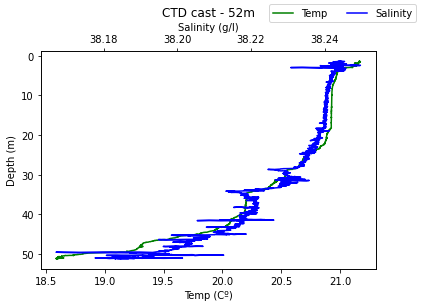

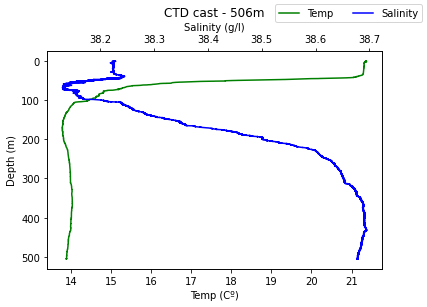

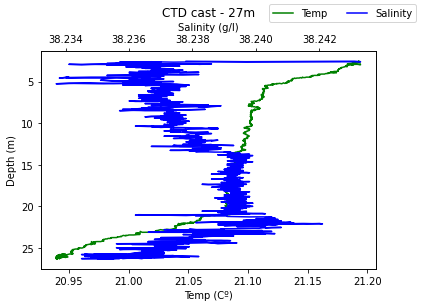

In [9]:
# CTD
parent_dir = 'MIR_BOAT_DAY1_DATA/MIR_DAY1/'
files_list = os.listdir(parent_dir)

#We loop trough the files in the directory
for file in files_list:
    #We select only the cnv files 
    if file[-3:]=='cnv':
        # we get the file name and we open it using ctd module
        fname = os.path.join(parent_dir, file)
        down, up = ctd.from_cnv(fname).split()

        #We plot the data recorded going down
        y = down.index.to_list()
        #We get the tempeture and salinity
        x1 = down['t090C'].to_list()
        x2 = down['sal00'].to_list()
        #Create the figure
        fig, ax1 = plt.subplots()
        ax2 = ax1.twiny()
        ax1.plot(x1, y, 'g-', label="Temp")
        ax1.set_xlabel("Temp (Cº)")
        ax1.set_ylabel("Depth (m)")
        ax2.plot(x2, y, 'b-', label="Salinity")
        ax2.set_xlabel("Salinity (g/l)")
        plt.gca().invert_yaxis()
        plt.title(f"CTD cast - {int(np.ceil(max(y)))}m")

        fig.legend(['Temp', 'Salinity'], loc = 1, ncol=2)

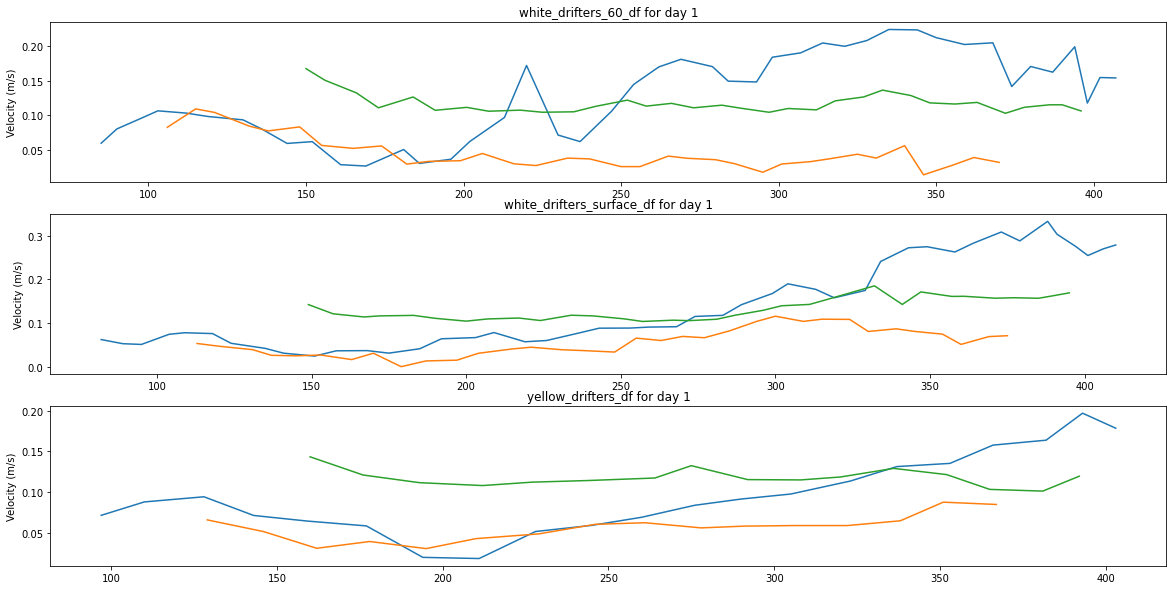

In [10]:
import matplotlib.pyplot as plt

# Create a figure with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(20, 10))

# # Iterate through the devices
# for i, (key, df) in enumerate(white_drifters_60_df.items()):
#     # Get the velocity data
#     velocities = df['velocity'][1:]
#     # Plot the velocity data
#     axs[0].plot(velocities)
#     # Set the title to the device id
#     axs[0].set_title("white_drifters_60_df for day 1")
#     axs[0].set_ylabel("Velocity (m/s)")
#     axs[0].legend([key])

count = 0
for i, (key, df) in enumerate(white_drifters_60_df.items()):
    if count == 3:
      break
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data
    axs[0].plot(velocities)
    # Set the title to the device id
    axs[0].set_title("white_drifters_60_df for day 1")
    axs[0].set_ylabel("Velocity (m/s)")
    #axs[0].legend([key])
    count += 1

for i, (key, df) in enumerate(white_drifters_surface_df.items()):
    velocities = df['velocity'][1:]
    axs[1].plot(velocities)
    axs[1].set_title("white_drifters_surface_df for day 1")
    axs[1].set_ylabel("Velocity (m/s)")
    #axs[1].legend([key])

for i, (key, df) in enumerate(yellow_drifters_df.items()):
    velocities = df['velocity'][1:]
    axs[2].plot(velocities)
    axs[2].set_title("yellow_drifters_df for day 1")
    axs[2].set_ylabel("Velocity (m/s)")
    #axs[2].legend([key])

# Show the plots
plt.show()


0.22341536152328031
0.33256013022677755
0.19671795764416697


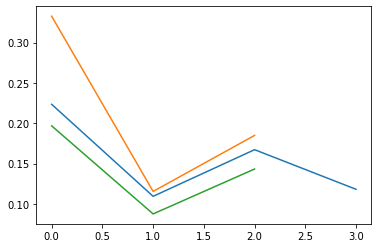

In [11]:
import matplotlib.pyplot as plt

# Initialize variables to store mean, min, and max velocities
mean_velocity_white_drifters_60_df = []
min_velocity_white_drifters_60_df = []
max_velocity_white_drifters_60_df = []
mean_velocity_white_drifters_surface_df = []
min_velocity_white_drifters_surface_df = []
max_velocity_white_drifters_surface_df = []
mean_velocity_yellow_drifters_df = []
min_velocity_yellow_drifters_df = []
max_velocity_yellow_drifters_df = []

# Calculate mean, min, and max velocities for white_drifters_60_df
for key, df in white_drifters_60_df.items():
    mean_velocity_white_drifters_60_df.append(df['velocity'].mean())
    min_velocity_white_drifters_60_df.append(df['velocity'].min())
    max_velocity_white_drifters_60_df.append(df['velocity'].max())

# Calculate mean, min, and max velocities for white_drifters_surface_df
for key, df in white_drifters_surface_df.items():
    mean_velocity_white_drifters_surface_df.append(df['velocity'].mean())
    min_velocity_white_drifters_surface_df.append(df['velocity'].min())
    max_velocity_white_drifters_surface_df.append(df['velocity'].max())

# Calculate mean, min, and max velocities for yellow_drifters_df
for key, df in yellow_drifters_df.items():
    mean_velocity_yellow_drifters_df.append(df['velocity'].mean())
    min_velocity_yellow_drifters_df.append(df['velocity'].min())
    max_velocity_yellow_drifters_df.append(df['velocity'].max())

# # Plot the mean, min, and max velocities for each dictionary
# plt.plot(mean_velocity_white_drifters_60_df, label="Mean velocity (white_drifters_60_df)")
# plt.plot(min_velocity_white_drifters_60_df, label="Minimum velocity (white_drifters_60_df)")
plt.plot(max_velocity_white_drifters_60_df, label="Maximum velocity (white_drifters_60_df)")
# plt.plot(mean_velocity_white_drifters_surface_df, label="Mean velocity (white_drifters_surface_df)")
# plt.plot(min_velocity_white_drifters_surface_df, label="Minimum velocity (white_drifters_surface_df)")
plt.plot(max_velocity_white_drifters_surface_df, label="Maximum velocity (white_drifters_surface_df)")
plt.plot(max_velocity_yellow_drifters_df, label="Maximum velocity (white_drifters_surface_df)")
print(max(max_velocity_white_drifters_60_df))
print(max(max_velocity_white_drifters_surface_df))
print(max(max_velocity_yellow_drifters_df))


In [12]:
# Initialize variables to store mean velocities
mean_velocity_white_drifters_60_df = 0
mean_velocity_white_drifters_surface_df = 0
mean_velocity_yellow_drifters_df = 0


# Calculate mean velocity for white_drifters_60_df
for key, df in white_drifters_60_df.items():
    mean_velocity_white_drifters_60_df += df['velocity'][1:].mean()
mean_velocity_white_drifters_60_df /= len(white_drifters_60_df)

# Calculate mean velocity for white_drifters_surface_df
for key, df in white_drifters_surface_df.items():
    mean_velocity_white_drifters_surface_df += df['velocity'][1:].mean()
mean_velocity_white_drifters_surface_df /= len(white_drifters_surface_df)

# Calculate mean velocity for yellow_drifters_df
for key, df in yellow_drifters_df.items():
    mean_velocity_yellow_drifters_df += df['velocity'][1:].mean()
mean_velocity_yellow_drifters_df /= len(yellow_drifters_df)


In [13]:
# Print mean velocities
print("Mean velocity for white_drifters_60_df:", mean_velocity_white_drifters_60_df)
print("Mean velocity for white_drifters_surface_df:", mean_velocity_white_drifters_surface_df)
print("Mean velocity for yellow_drifters_df:", mean_velocity_yellow_drifters_df)


Mean velocity for white_drifters_60_df: 0.09966378397317419
Mean velocity for white_drifters_surface_df: 0.11002044798537007
Mean velocity for yellow_drifters_df: 0.08999769958618405


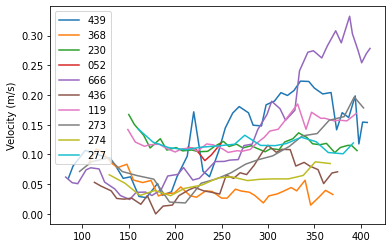

In [14]:
#Create a new figure
plt.figure()

#Iterate through the devices
for key, df in white_drifters_60_df.items():
    # Get the velocity data
    velocities = df['velocity'][1:]
    # Plot the velocity data
    plt.plot(velocities, label=key)
    # Set the title to the device id
    #plt.title(key)
    # Set the y-axis label to "Velocity (m/s)"
    plt.ylabel("Velocity (m/s)")

for key, df in white_drifters_surface_df.items():
    velocities = df['velocity'][1:]
    plt.plot(velocities, label=key)

for key, df in yellow_drifters_df.items():
    velocities = df['velocity'][1:]
    plt.plot(velocities, label=key)

#Show the plot
plt.legend()
plt.show()